<a href="https://colab.research.google.com/github/MMAMAR/stage-/blob/master/SST2SSH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install netCDF4
import netCDF4
import numpy as np

from datetime import datetime,date
import matplotlib.pyplot as plt 
import os

     |████████████████████████████████| 4.1MB 2.7MB/s 
     |████████████████████████████████| 327kB 54.6MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import requests


In [0]:
import os
os.chdir('/content/drive/My Drive')
import lap_diffusionMask
from scipy import interpolate

In [0]:
import scipy.fftpack as fftpack
from scipy import ndimage
def compute_PSD1D(I):

    W = np.reshape(np.hanning(I.shape[0]),(I.shape[0],1)) * np.reshape(np.hanning(I.shape[1]),(I.shape[1],1)).transpose() 

    F1 = fftpack.fft2( W * I) 
    F2 = fftpack.fftshift( F1 ) 
    psd2D = np.abs( F2 )**2
    
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(np.int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.sum(psd2D, r, index=np.arange(0, wc))

    return psd1D


In [8]:
#os.chdir('/Users/rfablet/Research/Data')
## test for filtering
filename = '/content/drive/My Drive/CMEMSData/global-analysis-forecast-phy-001-024-201901.nc'

## field info
SSHfieldname     = 'zos'
SSTfieldname     = 'thetao'
Latfieldname    = 'latitude'
Lonfieldname    = 'longitude'
Timefieldname   = 'time' ## time given in seconds

        
print('..... Open monthly file: '+filename)
nc_fid = netCDF4.Dataset(filename,'r')

Lats=nc_fid[Latfieldname]
Lons=nc_fid[Lonfieldname]
sstfield = nc_fid['thetao'][:,0,:,:]
sstfield=sstfield[0]
sstfield=sstfield.reshape(241,601)
Lats=Lats[0:50]
Lons=Lons[0:50]

..... Open monthly file: /content/drive/My Drive/CMEMSData/global-analysis-forecast-phy-001-024-201901.nc


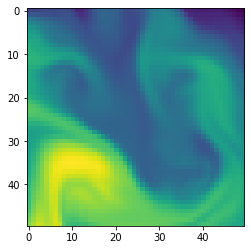

In [9]:
from sklearn.feature_extraction import image
X_patches=image.extract_patches_2d(sstfield, (50, 50), max_patches= 100, random_state=0)
Mask_patches=image.extract_patches_2d(sstfield.mask, (50, 50), max_patches= 100, random_state=0)

x_train=[]
maskes=[]

for i in range(len(X_patches)):
  if np.sum(Mask_patches[i]==True)==0:
    x_train.append(X_patches[i])
    maskes.append(Mask_patches[i])

plt.figure()
plt.imshow(x_train[0])
plt.show()

sstfield=x_train[1]

# tag mohamed

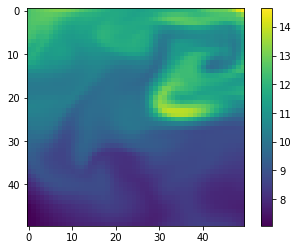

....... Filtering fine-scale for regridding


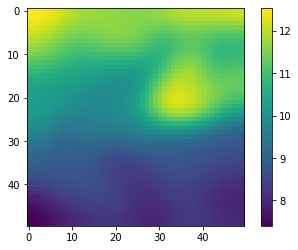

In [10]:

plt.figure(1)
imgplot=plt.imshow(np.flipud(sstfield))

plt.colorbar()
plt.show()



print("....... Filtering fine-scale for regridding")
LamScale   = 0.2

IterScale  = 100
if IterScale > 0:
    sstFilt_HR = lap_diffusionMask.lap_diffusionMask(sstfield,IterScale,LamScale)
else:
    sstFilt_HR = sstfield.copy()



plt.figure(2)
imgplot=plt.imshow(np.flipud(sstFilt_HR))
plt.colorbar()
plt.show()




In [11]:
res = 0.006
lat = np.arange(Lats[0],Lats[-1],res)
lon = np.arange(Lons[0],Lons[-1],res)

print("....... Regridding")
finterp = interpolate.interp2d(Lons,Lats,sstFilt_HR, kind='cubic')
sstHRi    = finterp(lon,lat)

....... Regridding


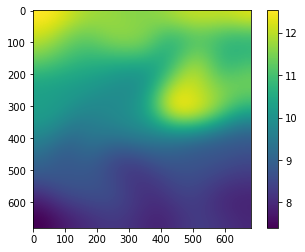

In [12]:
plt.figure()
imgplot=plt.imshow(np.flipud(sstHRi))

plt.colorbar()
plt.show()


....... Low-pass filtering


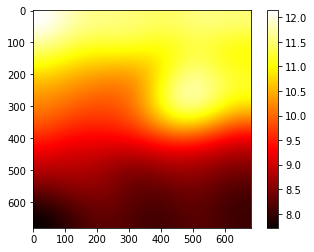

[-50.  -49.9 -49.8 -49.7 -49.6 -49.5 -49.4 -49.3 -49.2 -49.1 -49.  -48.9
 -48.8 -48.7 -48.6 -48.5 -48.4 -48.3 -48.2 -48.1 -48.  -47.9 -47.8 -47.7
 -47.6 -47.5 -47.4 -47.3 -47.2 -47.1 -47.  -46.9 -46.8 -46.7 -46.6 -46.5
 -46.4 -46.3 -46.2 -46.1 -46. ]


In [13]:
print("....... Low-pass filtering")
IterScale  = 100
sstLRi = lap_diffusionMask.lap_diffusionMask(sstHRi,IterScale,LamScale)

IterScale  = 100
if IterScale > 0 :
    resLR = 0.1
    latLR = np.arange(Lats[0],Lats[-1],resLR)
    lonLR = np.arange(Lons[0],Lons[-1],resLR)
    finterp = interpolate.interp2d(lon,lat,sstLRi, kind='cubic')
    sstLRi  = finterp(lonLR,latLR)
    
    sstLRi = lap_diffusionMask.lap_diffusionMask(sstLRi,IterScale,LamScale)
    finterp = interpolate.interp2d(lonLR,latLR,sstLRi, kind='cubic')
    sstLRi  = finterp(lon,lat)



plt.figure()
imgplot=plt.imshow(np.flipud(sstLRi))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()
print(latLR)

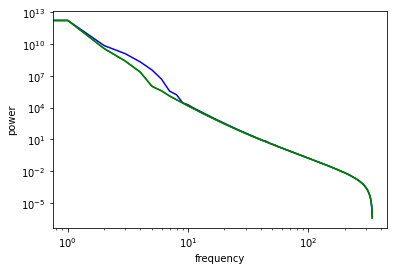

In [14]:
psd1D1=compute_PSD1D(sstHRi)
psd1D2=compute_PSD1D(sstLRi)
psd1D3=compute_PSD1D(sstfield)
plt.figure()
plt.plot(np.arange(len(psd1D1)),psd1D1, 'b')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("frequency")
plt.ylabel("power")

plt.plot(np.arange(len(psd1D2)),psd1D2, 'g')
plt.yscale("log")
plt.xscale("log")

plt.plot(np.arange(len(psd1D2)),psd1D2, 'g')
plt.yscale("log")
plt.xscale("log")


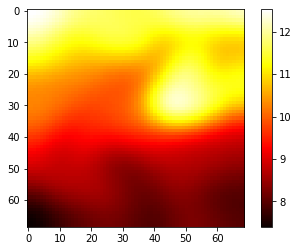

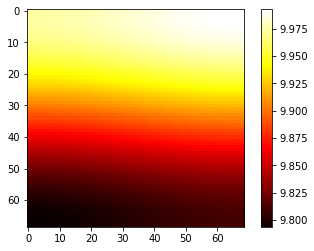

In [15]:
def GetHRData(I,IterScale,LamScale,res,Lats,Lons):
  #....... Filtering fine-scale for regridding

  if IterScale > 0:
    sstFilt_HR = lap_diffusionMask.lap_diffusionMask(I,IterScale,LamScale)
  else:
    sstFilt_HR = I.copy()

  
  lat = np.arange(Lats[0],Lats[-1],res)
  lon = np.arange(Lons[0],Lons[-1],res)

  #....... Regridding
  finterp = interpolate.interp2d(Lons,Lats,sstFilt_HR, kind='cubic')
  sstHRi    = finterp(lon,lat)

  return sstHRi

def GetLRData(I,IterScale,LamScale,res,resLR,Lats,Lons):
  sstLRi = lap_diffusionMask.lap_diffusionMask(I,IterScale,LamScale)
  if IterScale > 0 :
    lat = np.arange(Lats[0],Lats[-1],res)
    lon = np.arange(Lons[0],Lons[-1],res)
    latLR = np.arange(Lats[0],Lats[-1],resLR)
    lonLR = np.arange(Lons[0],Lons[-1],resLR)
    finterp = interpolate.interp2d(lon,lat,sstLRi, kind='cubic')
    sstLRi  = finterp(lonLR,latLR)
    
    sstLRi = lap_diffusionMask.lap_diffusionMask(sstLRi,IterScale,LamScale)
    finterp = interpolate.interp2d(lonLR,latLR,sstLRi, kind='cubic')
    sstLRi  = finterp(lon,lat)

  return sstLRi


sstHRii=GetHRData(sstfield,100,0.2,0.06,Lats,Lons)
plt.figure()
imgplot=plt.imshow(np.flipud(sstHRii))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()

sstLRii=GetLRData(sstHRii,100,0.2,0.06,1,Lats,Lons)
plt.figure()
imgplot=plt.imshow(np.flipud(sstLRii))
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()


## Preprocessing 

In [140]:
!pip install netcdf4

In [0]:
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.feature_extraction import image
from netCDF4 import Dataset
import numpy.ma as ma

In [142]:
os.chdir('/content/drive/My Drive/')
!pwd
!ls /content/drive/My\ Drive/CMEMSData

/content/drive/My Drive
global-analysis-forecast-phy-001-024-201810.nc
global-analysis-forecast-phy-001-024-201811.nc
global-analysis-forecast-phy-001-024-201812.nc
global-analysis-forecast-phy-001-024-201901.nc
global-analysis-forecast-phy-001-024-201902.nc
global-analysis-forecast-phy-001-024-201903.nc
global-analysis-forecast-phy-001-024-201904.nc


In [143]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
Maskes=[]
train_files=['global-analysis-forecast-phy-001-024-201812.nc','global-analysis-forecast-phy-001-024-201902.nc']
test_files=['global-analysis-forecast-phy-001-024-201901.nc']

# trainning data

for f in train_files:
  nc_data     = Dataset('./CMEMSData/'+f,'r')
  ssh = nc_data['zos'][:,:,:]
  sst = nc_data['thetao'][:,0,:,:]
  for i in range(len(sst)):
    X=np.flipud(sst[i,:,:]).data
    Y=np.flipud(ssh[i,:,:]).data
    XY_mask=np.flipud(ssh[i,:,:]).mask
    X_patches=image.extract_patches_2d(X, (50, 50), max_patches= 100, random_state=0)
    Y_patches=image.extract_patches_2d(Y, (50, 50), max_patches= 100, random_state=0)
    Mask_patches=image.extract_patches_2d(XY_mask, (50, 50), max_patches= 100, random_state=0)

    for j in range(len(X_patches)):
      X_train.append(X_patches[j])
      Y_train.append(Y_patches[j])
      Maskes.append(Mask_patches[j])

x_train=[]
y_train=[]

for i in range(len(X_train)):
  if np.sum(Maskes[i]==True)==0:
    x_train.append(X_train[i])
    y_train.append(Y_train[i])

print(len(x_train))
print(len(y_train))

#test data

Maskes=[]
for f in test_files:
  nc_data     = Dataset('./CMEMSData/'+f,'r')
  ssh = nc_data['zos'][:,:,:]
  sst = nc_data['thetao'][:,0,:,:]
  for i in range(len(sst)):
    X=np.flipud(sst[i,:,:]).data
    Y=np.flipud(ssh[i,:,:]).data
    XY_mask=np.flipud(ssh[i,:,:]).mask
    X_patches=image.extract_patches_2d(X, (50, 50), max_patches= 100, random_state=0)
    Y_patches=image.extract_patches_2d(Y, (50, 50), max_patches= 100, random_state=0)
    Mask_patches=image.extract_patches_2d(XY_mask, (50, 50), max_patches= 100, random_state=0)

    for j in range(len(X_patches)):
      X_test.append(X_patches[j])
      Y_test.append(Y_patches[j])
      Maskes.append(Mask_patches[j])

x_test=[]
y_test=[]

for i in range(len(X_test)):
  if np.sum(Maskes[i]==True)==0:
    x_test.append(X_test[i])
    y_test.append(Y_test[i])

print(len(x_test))
print(len(y_test))
X=[x_train,x_test]
Y=[y_train,y_test]
Mx1=np.array([np.mean(x) for x in x_train]).mean()
My1=np.array([np.mean(y) for y in y_train]).mean()
Mx2=np.array([np.mean(x) for x in x_test]).mean()
My2=np.array([np.mean(y) for y in y_test]).mean()
print(Mx1)
print(My1)
print(Mx2)
print(My2)

#Moyenne non spacialisée

x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)

x_train=x_train-Mx1
y_train=y_train-My1
x_test=x_test-Mx2
y_test=y_test-My2


x_train,y_train=shuffle(x_train,y_train, random_state=0)
x_test,y_test=shuffle(x_test,y_test, random_state=0)

"""
x_train=torch.Tensor(x_train)
y_train=torch.Tensor(y_train)
x_test=torch.Tensor(x_test)
y_test=torch.Tensor(y_test)
"""

5605
5605
2945
2945
15.594807103916969
0.0060345840484668225
15.615132012611205
0.02577029756980937


'\nx_train=torch.Tensor(x_train)\ny_train=torch.Tensor(y_train)\nx_test=torch.Tensor(x_test)\ny_test=torch.Tensor(y_test)\n'

In [145]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]

for i in range(len(x_train)):
  X_train.append(GetHRData(x_train[i],100,0.2,0.06,Lats,Lons))
  Y_train.append(GetHRData(y_train[i],100,0.2,0.06,Lats,Lons))
print("...............done")
  

for i in range(len(x_test)):
  X_test.append(GetHRData(x_test[i],100,0.2,0.06,Lats,Lons))
  Y_test.append(GetHRData(y_test[i],100,0.2,0.06,Lats,Lons))
  
print("...............done")



...............done
...............done


In [146]:
print(np.array(X_train).shape)
print(np.array(Y_train).shape)
print(np.array(X_test).shape)
print(np.array(Y_test).shape)


(5605, 69, 69)
(5605, 69, 69)
(2945, 69, 69)
(2945, 69, 69)


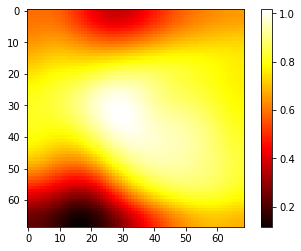

In [147]:
plt.figure()
imgplot=plt.imshow(Y_test[0])
imgplot.set_cmap('hot')
plt.colorbar()
plt.show()

In [0]:
del x_train, y_train, x_test, y_test, X_patches, Y_patches, Mask_patches


In [0]:
X_train=torch.Tensor(X_train)/10
Y_train=torch.Tensor(Y_train)/2
X_test=torch.Tensor(X_test)/10
Y_test=torch.Tensor(Y_test)/2

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3,padding= (2,2))
        self.conv2 = nn.Conv2d(32, 32, 3,padding= (1,1))
        self.conv3 = nn.Conv2d(32, 1, 3,padding= (0,0))
    
    def forward(self, x):
      x=F.relu(self.conv1(x))
      x=F.relu(self.conv2(x))
      x=self.conv3(x)

      return(x)
net= Net()

In [0]:
lossfunction=nn.MSELoss()
optimizer=optim.Adam(net.parameters(), lr=0.00001)

In [152]:
epochs= 20
batch_size= 500

for i in range(epochs):
  #running_loss=0 
  
  for j in range(0,len(X_train), batch_size):
    X = X_train[j:j+batch_size].view(-1, 1, 69, 69)
    Y = Y_train[j:j+batch_size].view(-1, 1, 69, 69)
    optimizer.zero_grad()
    outputs = net(X)
    loss = lossfunction(outputs, Y)
    loss.backward()
    optimizer.step()
    #running_loss+=loss.item()

    if j==5000:
      print("epoch=",i,"; running_loss=", loss.item())

epoch= 0 ; running_loss= 0.02330235205590725
epoch= 1 ; running_loss= 0.022458933293819427
epoch= 2 ; running_loss= 0.021657943725585938
epoch= 3 ; running_loss= 0.020908834412693977
epoch= 4 ; running_loss= 0.020208273082971573
epoch= 5 ; running_loss= 0.01954013668000698
epoch= 6 ; running_loss= 0.018874285742640495
epoch= 7 ; running_loss= 0.018222352489829063
epoch= 8 ; running_loss= 0.017594341188669205
epoch= 9 ; running_loss= 0.01701442338526249
epoch= 10 ; running_loss= 0.016485612839460373
epoch= 11 ; running_loss= 0.01599710062146187
epoch= 12 ; running_loss= 0.015538127161562443
epoch= 13 ; running_loss= 0.015077704563736916
epoch= 14 ; running_loss= 0.014611391350626945
epoch= 15 ; running_loss= 0.014156140387058258
epoch= 16 ; running_loss= 0.013740547001361847
epoch= 17 ; running_loss= 0.013366655446588993
epoch= 18 ; running_loss= 0.013033364899456501
epoch= 19 ; running_loss= 0.012730849906802177


In [0]:
 outputs=net.forward(X_test.view(-1, 1, 69, 69))

In [0]:
outputs=outputs.view(-1,69,69)

In [155]:
X_train[6].max()

tensor(0.1213)

tensor(0.0298)


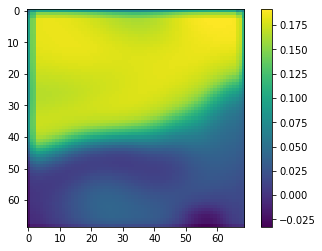

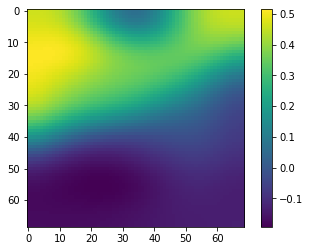

In [159]:
i=3
plt.figure()
plt.imshow(outputs[i].data)
plt.colorbar()

plt.figure()
plt.imshow(Y_test[i])
plt.colorbar()

loss_fn = nn.MSELoss()
MSE=loss_fn(outputs[i].data,Y_test[i])
print(MSE)


In [157]:

MSE=loss_fn(outputs.data,Y_test)
eff=1-MSE/Y_test.var()
print("efficience: ", float(eff.data))

efficience:  0.7500894069671631


## Evaluation par le laplacien





In [158]:
from scipy.sparse import csgraph

output_laplacian= []
test_laplacian= []
for i in range(len(Y_test)):
  output_laplacian.append(csgraph.laplacian(outputs.data[i]))
  test_laplacian.append(csgraph.laplacian(Y_test[i]))
output_laplacian= torch.Tensor(output_laplacian)
test_laplacian= torch.Tensor(test_laplacian)


MSE=loss_fn(output_laplacian, test_laplacian)
eff=1-MSE/test_laplacian.var()
print("lapalacian_efficience: ", float(eff))

lapalacian_efficience:  0.819929301738739
